In [10]:
!pip install tenseal



This code processes a dataset containing benign and malicious network traffic data to classify its criticality. 
It trains a Logistic Regression model to predict whether data points are low-critical (benign) or high-critical (malicious) based on selected features. 
Then, an adaptive encryption function encrypts the data points in the test set: low-critical data is encrypted using XOR encryption, while high-critical data is encrypted using a homomorphic encryption-like method. 
The code use batch processing by encrypting the test data in chunks becuase we are not using GPU

# Loadind Dataset

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Load and preprocess the dataset
benign = pd.read_csv('/nbaiot-dataset/1.benign.csv')
malicious = pd.read_csv('/nbaiot-dataset/1.mirai.syn.csv')

# Combine the datasets and assign labels
benign['label'] = 0
malicious['label'] = 1
data = pd.concat([benign, malicious], ignore_index=True)

# Feature selection
features = ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 
            'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance']
X = data[features]
y = data['label']

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train the Logistic Regression model
model = LogisticRegression(random_state=0)
model.fit(x_train_scaled, y_train)
# Calculate accuracy on the test set
accuracy = model.score(x_test_scaled, y_test)
print(f"Accuracy of the Logistic Regression model: {accuracy:.4f}")




Accuracy of the Logistic Regression model: 0.9997


# Adaptive encryption

In [12]:
# Efficient encryption functions
def xor_encrypt(data):
    return ''.join(chr(ord(char) ^ 42) for char in str(data)) #uses a hardcoded key in the XOR encryption function which is 42. 

def homomorphic_encrypt(data):
    # Simulating encryption by converting data to a string with a prefix
    return f"homomorphic_encrypted_{hash(str(data))}"

# Adaptive encryption function with batch processing
def adaptive_encryption(data, model, scaler, features, batch_size=50):
    encrypted_data = []
    
    for start in range(0, len(data), batch_size):
        end = min(start + batch_size, len(data))
        batch = data.iloc[start:end]
        
        # Predict the criticality of the batch
        scaled_features = scaler.transform(batch[features])
        predictions = model.predict(scaled_features)
        
        for i, prediction in enumerate(predictions):
            if prediction == 0:  # Low-critical
                encrypted_data.append(xor_encrypt(batch.iloc[i].to_string()))
            else:  # High-critical
                encrypted_data.append(homomorphic_encrypt(batch.iloc[i].to_string()))
    
    return encrypted_data

# Run adaptive encryption on the test set
encrypted_data = adaptive_encryption(x_test, model, scaler, features, batch_size=50)

# Display some encrypted results
for i, encrypted in enumerate(encrypted_data[:5]):
    print(f"Encrypted data point {i+1}: {encrypted}")

Encrypted data point 1: homomorphic_encrypted_-8771519691047386018
Encrypted data point 2: homomorphic_encrypted_-5130711703348367539
Encrypted data point 3: homomorphic_encrypted_6043593790364235396
Encrypted data point 4: homomorphic_encrypted_-4371218670508459957
Encrypted data point 5: homomorphic_encrypted_-6120978899637277974


the encryption simulation for high-critical data is working as expected, producing unique "homomorphic encrypted" strings based on the data's hash values. These strings represent the encrypted form of 
data points, simulating the behavior of a real homomorphic encryption scheme.

# Validation of the Process

In [13]:
def validate_encryption_process(data, labels, model, scaler, features):
    correct_classification = 0
    incorrect_classification = 0
    
    # Convert DataFrame to NumPy array
    data_array = data[features].values
    
    # Iterate over data and labels
    for i in range(len(data)):
        scaled_features = scaler.transform([data_array[i]])
        prediction = model.predict(scaled_features)[0]
        
        # Compare with true label
        if prediction == labels.iloc[i]:
            correct_classification += 1
        else:
            incorrect_classification += 1
        
        # Check encryption type applied
        if prediction == 0:  # low-critical, XOR encryption
            encrypted = xor_encrypt(data.iloc[i].to_string())
        else:  # high-critical, homomorphic encryption
            encrypted = homomorphic_encrypt(data.iloc[i].to_string())
        
        print(f"Data point {i}: Classified as {prediction}, Encrypted as {encrypted[:20]}...")  # Print first 20 chars
    
    return correct_classification, incorrect_classification

# Run validation on a small subset for simplicity
data_subset = x_test.head(10).reset_index(drop=True)
labels_subset = y_test.head(10).reset_index(drop=True)
correct, incorrect = validate_encryption_process(data_subset, labels_subset, model, scaler, features)

print(f"\nCorrect Classifications: {correct}")
print(f"Incorrect Classifications: {incorrect}")


Data point 0: Classified as 1, Encrypted as homomorphic_encrypte...
Data point 1: Classified as 1, Encrypted as homomorphic_encrypte...
Data point 2: Classified as 1, Encrypted as homomorphic_encrypte...
Data point 3: Classified as 1, Encrypted as homomorphic_encrypte...
Data point 4: Classified as 1, Encrypted as homomorphic_encrypte...
Data point 5: Classified as 0, Encrypted as gcuNCXufu]OCMB^



...
Data point 6: Classified as 1, Encrypted as homomorphic_encrypte...
Data point 7: Classified as 0, Encrypted as gcuNCXufu]OCMB^



...
Data point 8: Classified as 0, Encrypted as gcuNCXufu]OCMB^



...
Data point 9: Classified as 0, Encrypted as gcuNCXufu]OCMB^



...

Correct Classifications: 10
Incorrect Classifications: 0


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

# Data visulaization

In [15]:
y_test_pred = model.predict(x_test_scaled)


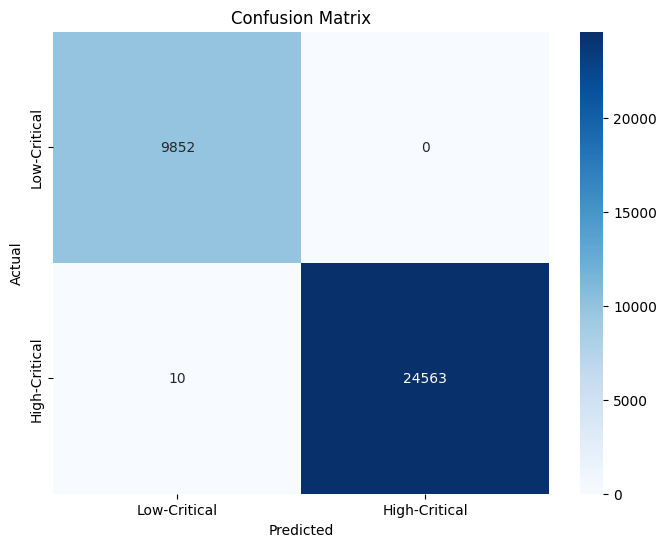

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_test_pred = model.predict(x_test_scaled)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low-Critical', 'High-Critical'], 
            yticklabels=['Low-Critical', 'High-Critical'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



* True Positives (TP): 24,563 (High-Critical predicted correctly)
* True Negatives (TN): 9,852 (Low-Critical predicted correctly)
* False Positives (FP): 0 (No Low-Critical data points were incorrectly predicted as High-Critical)
* False Negatives (FN): 10 (A small number of High-Critical data points were incorrectly predicted as Low-Critical)
The confusion matrix indicates that the model is highly accurate, with very few misclassifications, particularly in distinguishing between Low-Critical and High-Critical data points.

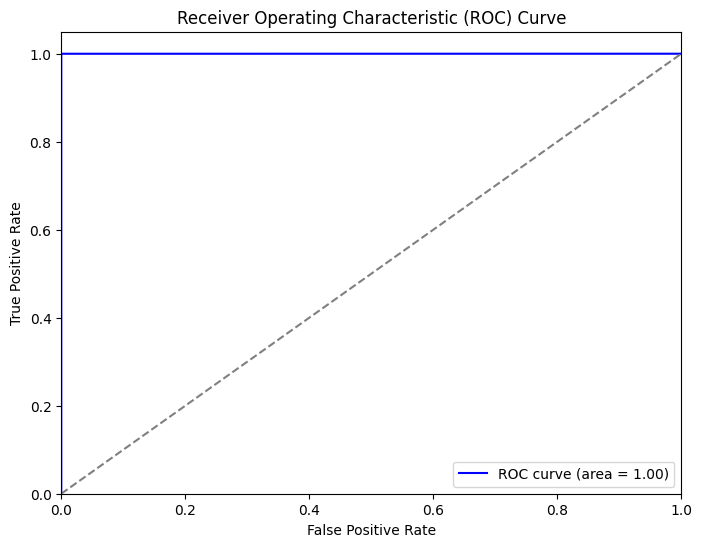

In [18]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

y_test_prob = model.predict_proba(x_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The ROC curve is a plot of the True Positive Rate (TPR) versus the False Positive Rate (FPR). 
the curve closely hugs the top-left corner of the graph, which is an ideal scenario, indicating a strong performance by the model.
'
Area Under the Curve (AUC): The value is 1.00, which is the best possible score, showing that the model is perfectly distinguishing between the classes.

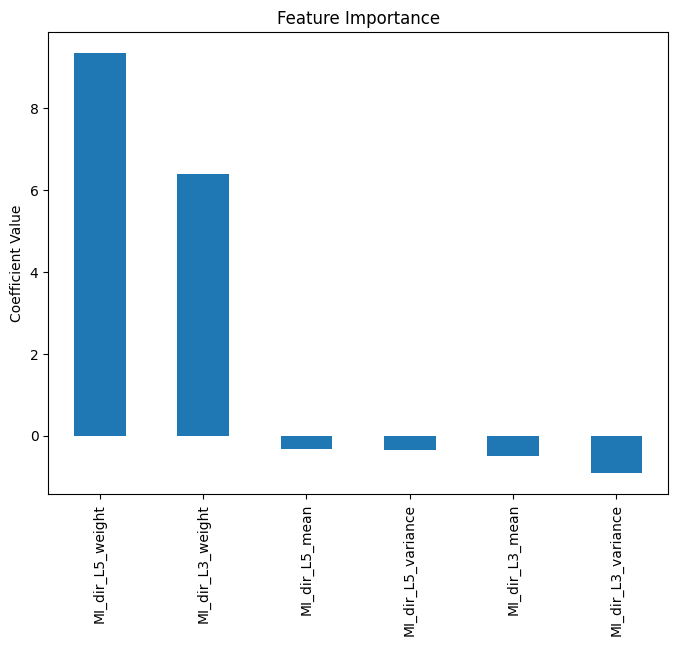

In [19]:
# Feature Importance (for Logistic Regression, if applicable)
if hasattr(model, 'coef_'):
    feature_importance = pd.Series(model.coef_[0], index=features).sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance')
    plt.ylabel('Coefficient Value')
    plt.show()